In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from arch import arch_model
from sklearn.linear_model import LinearRegression

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(20, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


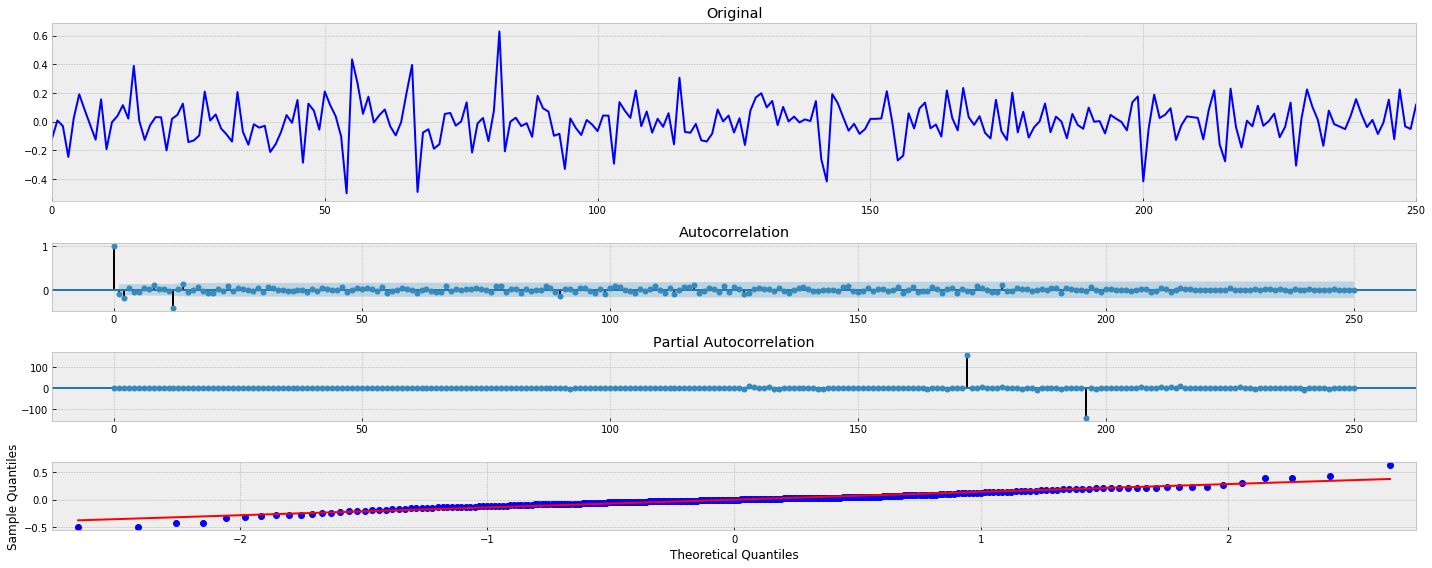

In [18]:
series_orig = df['Monthly U.S. auto registration (thousands) 1947 ? 1968']
series = boxcox(series_orig, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

#### Попробуем предсказать с помощью ARIMA несколько последних значений

In [12]:
train, val = series[:200], series[200:]


aic: -218.08723 | order: (4, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -6.397448e+00
p-value                        2.034232e-08
#Lags Used                     1.100000e+01
Number of Observations Used    1.880000e+02
Critical Value (1%)           -3.465620e+00
Critical Value (5%)           -2.877040e+00
Critical Value (10%)          -2.575032e+00
dtype: float64


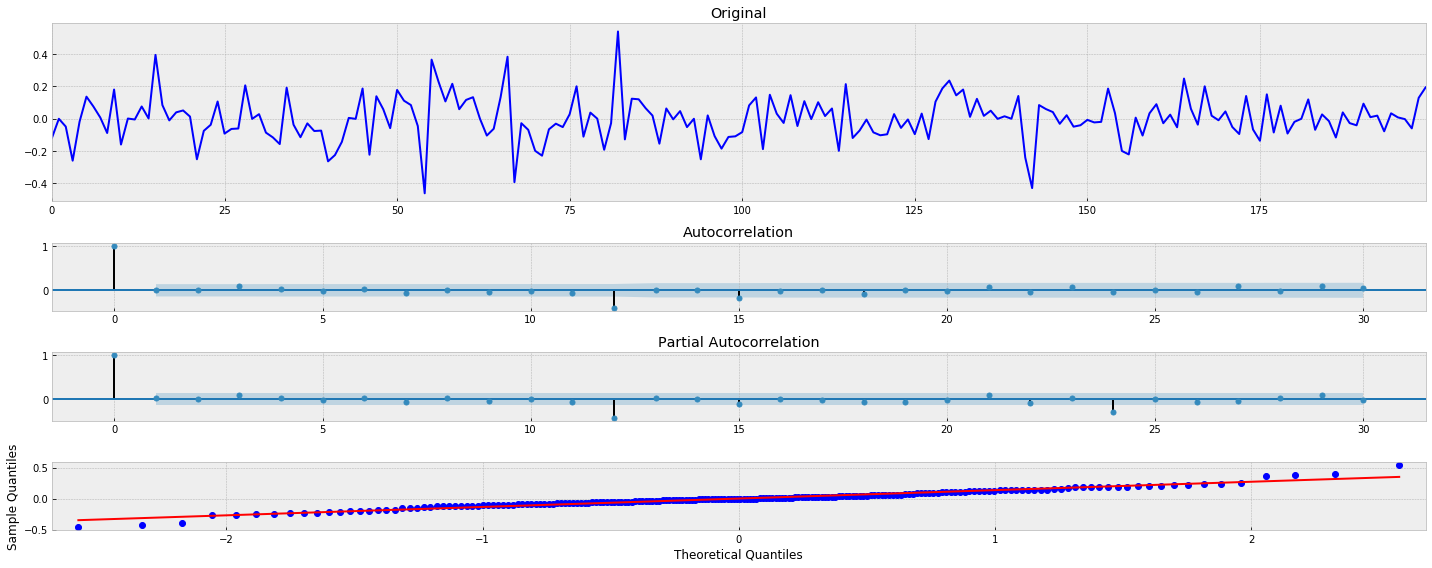

In [13]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in tqdm(range(5)):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

Остатки выглядят более-менее случайными

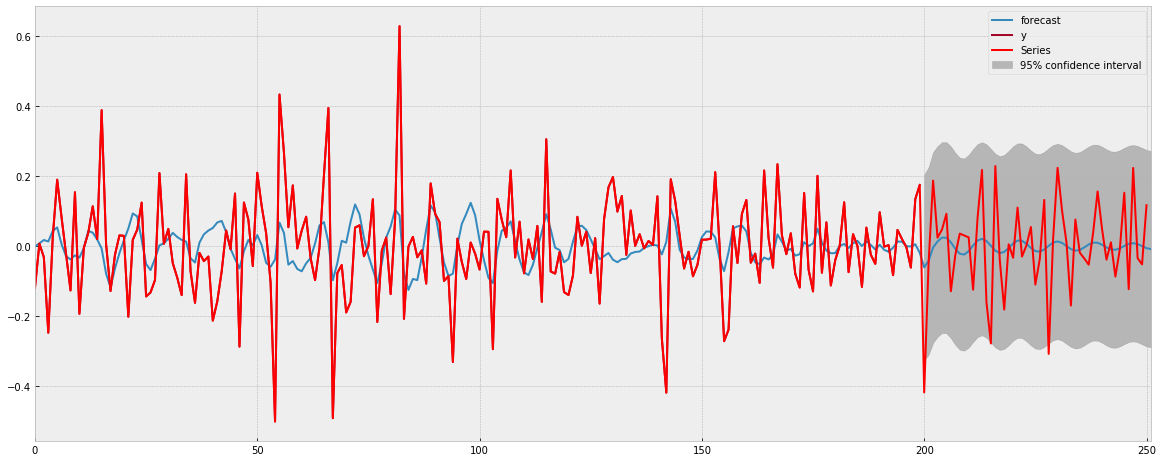

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series), ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Почти попали в доверительный интервал. Если подбирать параметры для всей последовательности, то они окажутся такими же.

#### GARCH

В качестве отправной точки для GARCH используем параметры, полученные с помощью модели ARIMA

In [35]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                120.812
Distribution:      Standardized Student's t   AIC:                          -223.623
Method:                  Maximum Likelihood   BIC:                          -193.938
                                              No. Observations:                  200
Date:                      Thu, May 09 2019   Df Residuals:                      191
Time:                              02:10:32   Df Model:                            9
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -6.002000e+00
p-value                        1.648907e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.880000e+02
Critical Value (1%)           -3.465620e+00
Critical Value (5%)           -2.877040e+00
Critical Value (10%)          -2.575032e+00
dtype: float64


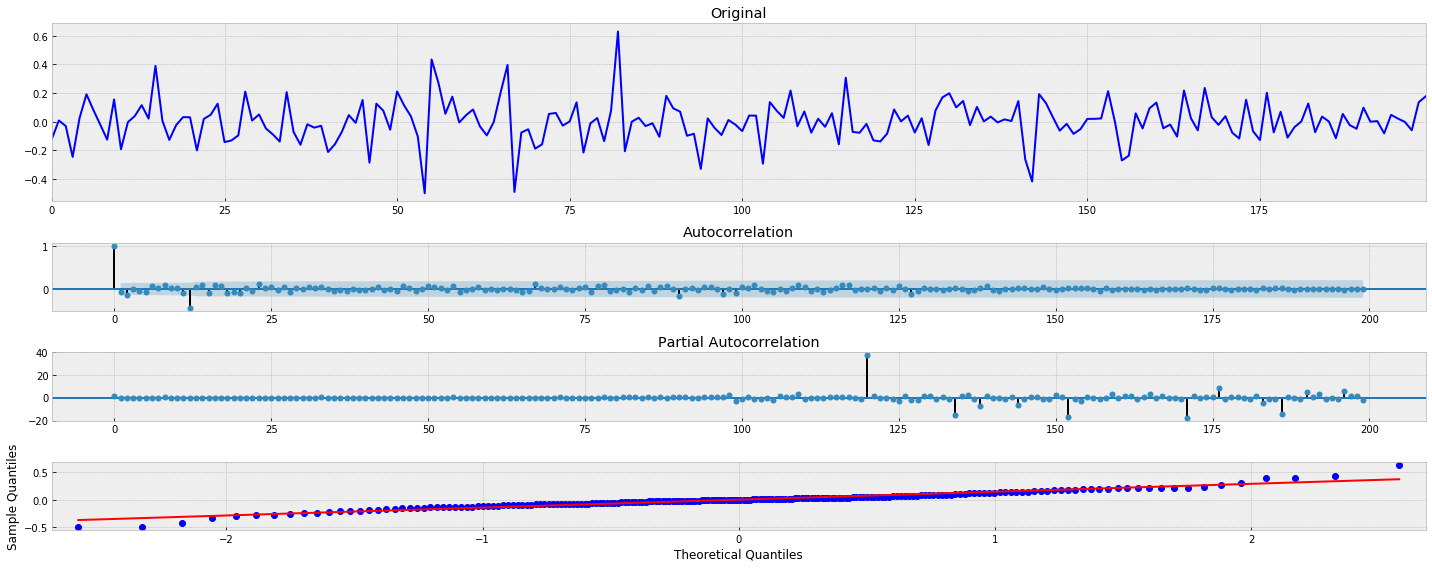

In [36]:
tsplot(res.resid)

Остатки в конце серии выглядят не очень, несмотря на хорошее значение p-value.

In [47]:
pred = res.forecast(horizon=len(val), method='simulation', simulations=1000)

In [49]:
forecast = train.copy()
forecast = np.concatenate((forecast, pred.variance.values[-1, :]))

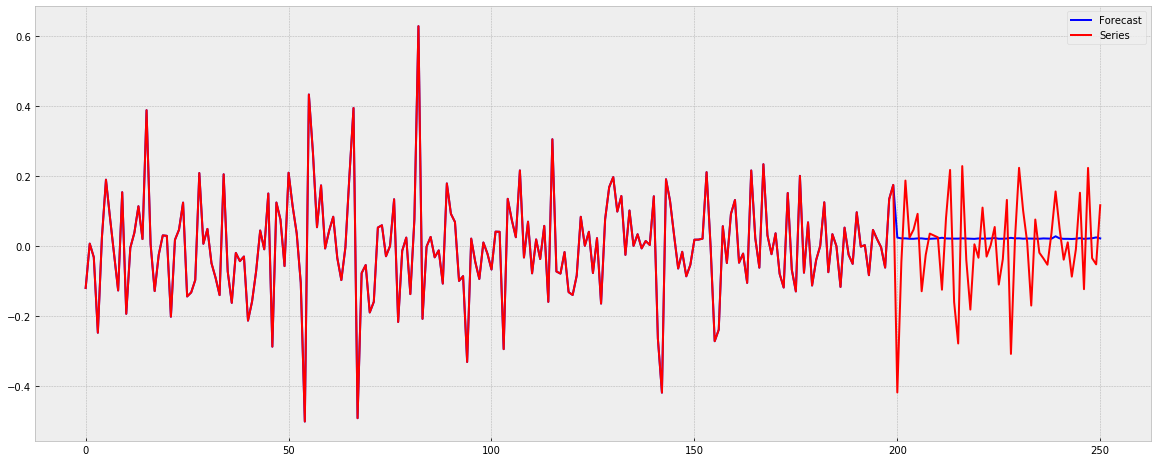

In [50]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plt.plot(forecast, color='blue', label='Forecast')
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

График получился даже хуже, чем для ARIMA.

#### Попробуем классический ML

In [29]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['reg']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['reg'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["reg"], axis=1)
    y_train = data.loc[:test_index]["reg"]
    X_test = data.loc[test_index:].drop(["reg"], axis=1)
    y_test = data.loc[test_index:]["reg"]
    
    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = prepareData(series_orig, lag_start=1, lag_end=20, test_size=0.3)

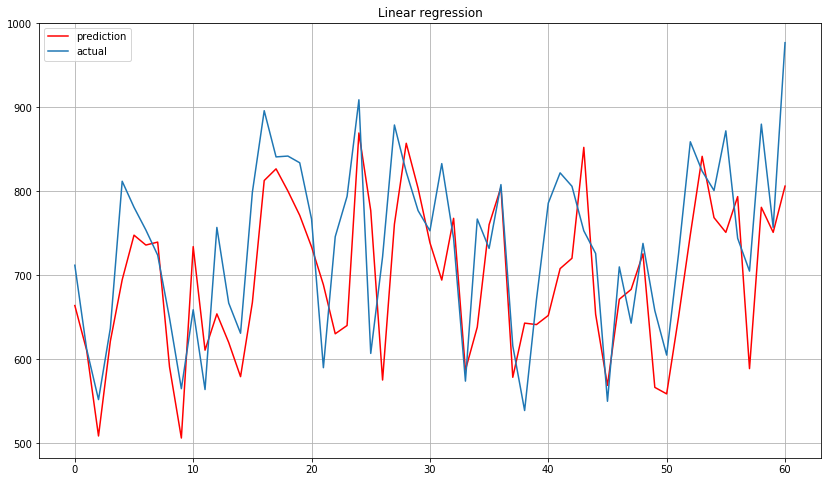

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

На удивление, получилось неплохо.